In [1]:
import pandas as pd, numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns 

from glob import glob
import cv2
from PIL import Image

In [2]:
df = pd.read_csv('/kaggle/input/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
df['path'] = df['Image Index'].map(tmp)

In [3]:
import cv2
import os
import random
import numpy as np

def NeedleAugmentation(image, n_needles=2, dark_needles=True, p=1.0, needle_folder='../input/xray-needle-augmentation'):
    aug_prob = random.random()
    if aug_prob < p:
        height, width, _ = image.shape  # target image width and height
        needle_images = [im for im in os.listdir(needle_folder) if 'png' in im]

        for _ in range(n_needles):  # Ensure correct number of needles
            needle = cv2.cvtColor(cv2.imread(os.path.join(needle_folder, random.choice(needle_images))), cv2.COLOR_BGR2RGB)
            needle = cv2.flip(needle, random.choice([-1, 0, 1]))
            needle = cv2.rotate(needle, random.choice([0, 1, 2]))

            h_height, h_width, _ = needle.shape  # needle image width and height
            roi_ho = random.randint(0, abs(image.shape[0] - needle.shape[0]))
            roi_wo = random.randint(0, abs(image.shape[1] - needle.shape[1]))
            roi = image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Resize needle to match ROI dimensions
            needle_resized = cv2.resize(needle, (roi.shape[1], roi.shape[0]), interpolation=cv2.INTER_AREA)

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(needle_resized, cv2.COLOR_RGB2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)


            # Now black-out the area of needle in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of needle from needle image
            if dark_needles:
                needle_fg = cv2.bitwise_and(img_bg, img_bg, mask=mask)
            else:
                needle_fg = cv2.bitwise_and(needle_resized, needle_resized, mask=mask)

            # Put needle in ROI and modify the target image
            dst = cv2.add(img_bg, needle_fg)

            image[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

    return image


**dark_needles=True**

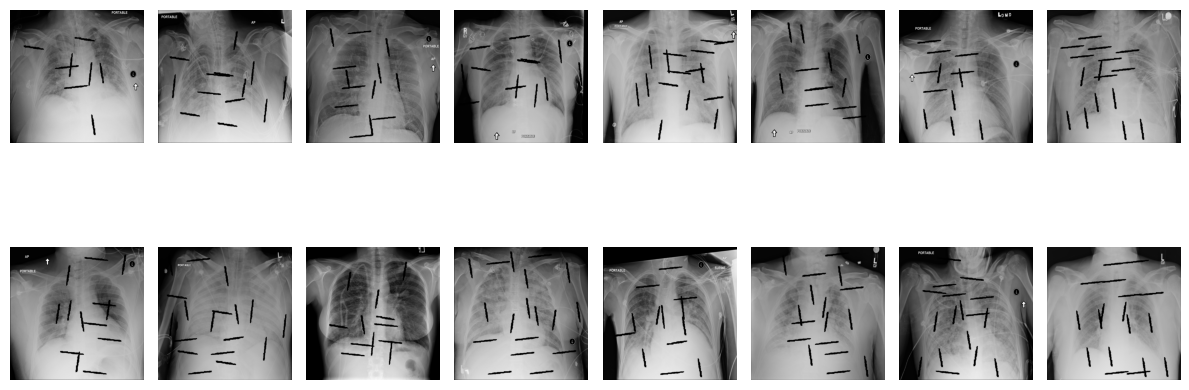

In [4]:
plt.figure(figsize=(12,6))

for i in range(16):
    plt.subplot(2,8,i+1)
    path = df.iloc[i]['path']
    img = cv2.imread(path)
    img = NeedleAugmentation(img)
    
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

**dark_needles=False**

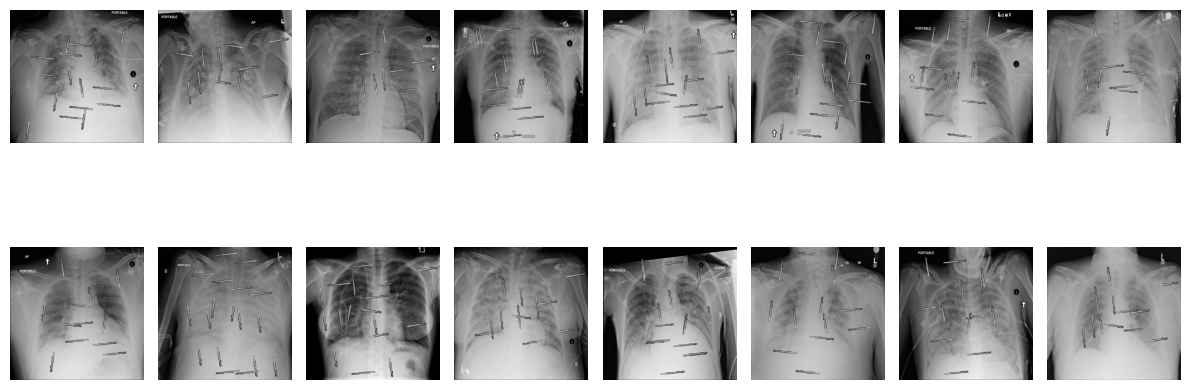

In [5]:
plt.figure(figsize=(12,6))

for i in range(16):
    plt.subplot(2,8,i+1)
    path = df.iloc[i]['path']
    img = cv2.imread(path)
    img = NeedleAugmentation(img,dark_needles=False)
    
    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()